## Prueba técnica

### Paso 1: Alcance del proyecto

Identificar features e hipótesis a través de descriptivos que permitan construir un modelo analítico que permita evidenciar las transacciones de mala práctica transaccional

### Paso 2: EDA

En el EDA, el propósito principal es entender la base y las variables que se tienen disponibles para hallar los usr con malas prácticas transaccionales. Esta base cuenta con 10.8M de registros del 01 de enero de 2021 hasta el 30 de noviembre de 2021. Durante este periodo de tiempo, 1.9M de usuarios realizaron transacciones, el 50% realiza hasta 2 trx y 460k (24%) usr realizan más de 5 trx. Finalmente, en los datos se observan temporalidades de cara a las trx.

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

In [2]:
# Carga de datos
df_1 = pd.read_parquet(r'C:\Users\egarcmor\Desktop\Nequi\sample_data_0006_part_00.parquet')


In [3]:
# Preprocesar datos
df_1['fecha'] = pd.to_datetime(df_1['transaction_date'])
df_1['date_1'] = df_1['fecha'].dt.strftime('%Y%m%d').astype(int)
df_1.head()

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,fecha,date_1
0,075d178871d8d48502bf1f54887e52fe,aa8dacff663072244d0a8ab6bbe36b93,824b2af470cbe6a65b15650e03b740fc,2021-09-12 18:32:03,648e257c9d74909a1f61c54b93a9e1b3,ba42d192a145583ba8e7bf04875f837f,178.33365037,CREDITO,2021-09-12 18:32:03,20210912
1,075d178871d8d48502bf1f54887e52fe,a53bb81bd0bba2ae2535bda7ea5a550c,2d8d34be7509a6b1262336d036fdb324,2021-09-12 18:31:58,c0b62f9046c83ea5543ea46a497a4d6e,5cfff960ea6d732c1ba3e63d24f3be52,35.66673007,CREDITO,2021-09-12 18:31:58,20210912
2,075d178871d8d48502bf1f54887e52fe,79f893ea65c06fe2933f3847c88c272f,5eeb18254850b21af0a6bb2697913cd3,2021-09-12 18:31:56,872d10143fc0ac7d5de467806f6bef81,c97e63a92c82c7217b333635d75928ed,142.66692029,CREDITO,2021-09-12 18:31:56,20210912
3,075d178871d8d48502bf1f54887e52fe,ce577223699dbdc119df2ab8a35457fe,5221a599856c0a0588ed9ffd150edd3b,2021-09-12 18:31:10,2e35cfe7860a480a93e1c83e99843579,fc09bdd00f283222d65eaff4d00a6594,8.32223701,CREDITO,2021-09-12 18:31:10,20210912
4,075d178871d8d48502bf1f54887e52fe,0ce7ab2950e7a788a608f881aec0f8f0,971e55ef12d80ec070ea4f6750c8b892,2021-09-12 18:31:07,995bc89e4c4e00334f1f90c4a55f4729,213527e8ba94fcaf2f9378969f9f6abc,32.10005706,CREDITO,2021-09-12 18:31:07,20210912


In [4]:
# Características de la base
print("shape", df_1.shape)
print('usr_trx', df_1['user_id'].nunique())
print('trx', df_1['_id'].nunique())
print("cols:", list(df_1.columns))
print("Tipo de datos")
df_1.dtypes

shape (10758418, 10)
usr_trx 1948844
trx 10758411
cols: ['merchant_id', '_id', 'subsidiary', 'transaction_date', 'account_number', 'user_id', 'transaction_amount', 'transaction_type', 'fecha', 'date_1']
Tipo de datos


merchant_id                   object
_id                           object
subsidiary                    object
transaction_date      datetime64[ns]
account_number                object
user_id                       object
transaction_amount            object
transaction_type              object
fecha                 datetime64[ns]
date_1                         int64
dtype: object

In [42]:
df_1['transaction_type'].value_counts()

transaction_type
DEBITO     8591289
CREDITO    2167129
Name: count, dtype: int64

In [5]:
# Validación de nulos:
print(df_1.isnull().sum())

merchant_id           0
_id                   0
subsidiary            0
transaction_date      0
account_number        0
user_id               0
transaction_amount    0
transaction_type      0
fecha                 0
date_1                0
dtype: int64


In [6]:
# Transacciones por usr
trx_usr = pd.DataFrame(df_1['user_id'].value_counts()).reset_index()
print(trx_usr.shape)

# usuarios con más de una transacción
trx_usr_obj = trx_usr[trx_usr['count']>1]
print(trx_usr_obj.shape)

trx_usr_obj.head()

(1948844, 2)
(1171465, 2)


,user_id,count
0,5e674596af22a66e826bf15b2a363cce,1900
1,d3720205290ca7444d216167dd4cb0b1,1728
2,e77fc30bb3bec8bf45a35b535b292047,1358
3,09ef9d0c0923b7f4848655f0de449603,1202
4,93bb7c11b0b58e233f56f50cd70c1a82,1200


In [40]:
trx_usr.describe().T

,count,mean,std,min,25%,50%,75%,max
count,1948844.0,5.52041,12.123418,1.0,1.0,2.0,5.0,1900.0


In [41]:
print(trx_usr[trx_usr['count']>5].shape)
print(trx_usr[trx_usr['count']<=5].shape)

(461380, 2)
(1487464, 2)


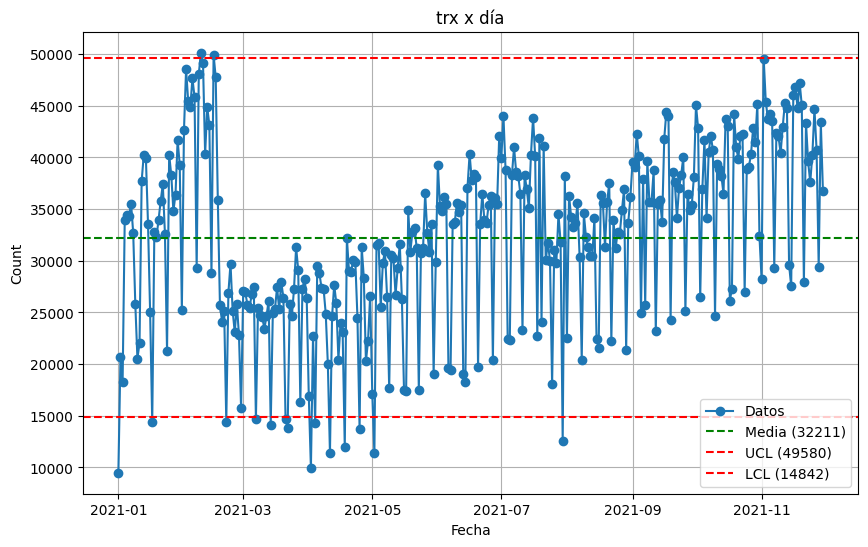

In [7]:
# Transacciones por día
aa = pd.DataFrame(df_1['date_1'].value_counts()).reset_index().sort_values(by='date_1')
aa['date_1'] = pd.to_datetime(aa['date_1'], format='%Y%m%d')

mean = aa['count'].mean()
std = aa['count'].std()
ucl = mean + 2 * std
lcl = mean - 2 * std

plt.figure(figsize=(10,6))
plt.plot(aa['date_1'], aa['count'], marker='o', label='Datos')
plt.axhline(mean, color='green', linestyle='--', label=f'Media ({mean:.0f})')
plt.axhline(ucl, color='red', linestyle='--', label=f'UCL ({ucl:.0f})')
plt.axhline(lcl, color='red', linestyle='--', label=f'LCL ({lcl:.0f})')

plt.title("trx x día")
plt.xlabel("Fecha")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

#### Paso 2.1: Análisis temporal

Para el análisis temporal tomamos los datos disponibles para los 11 meses y sobre este vamos a realizar todos los análisis. Para ello, vamos a calcular las trasacciones que se realizan cada usuario por día, el monto y el coeficiente de variación por tipo de transaccioón (Crédito/Débito). En síntesis, se observa que el monto promedio las trx de crédito es de 32.4$ mientras que los débito está alrededor de 191.0$ 

In [9]:
df_1_sample = df_1.sort_values(by='fecha').copy() # [df_1['date_1']<20210201]
df_1_sample.head()

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,fecha,date_1
2345854,817d18cd3c31e40e9bff0566baae7758,8c2df593436163e9cbff2fe3050f0ae1,c1b186a762110afc5d510517b04b6329,2021-01-01 00:01:13,a49b390b90de1454f966c604da9687d3,8c8b5512b0772dc891bef619ecd2acfb,47.55564009,DEBITO,2021-01-01 00:01:13,20210101
10048636,838a8fa992a4aa2fb5a0cf8b15b63755,6ed538998f04c804c299dc9fbc4d6e90,dff70ce33784a932ce4a7efc81a43863,2021-01-01 00:01:17,666e5e749c3ae3dea220e023a51c88f4,d0a25a8f11f7228d912e6874a0544d41,5.94445501,CREDITO,2021-01-01 00:01:17,20210101
9370118,838a8fa992a4aa2fb5a0cf8b15b63755,8801042a2192cdb8d96074442e5d4e06,d4b31b123120a4eefd51ba95975f2ae4,2021-01-01 00:01:45,c039cca9581596ee863c3c812835bfff,6b6113f0dfead46eb7f0c21ecb78d567,5.94445501,DEBITO,2021-01-01 00:01:45,20210101
9323529,838a8fa992a4aa2fb5a0cf8b15b63755,d7f0eb2060bf7bfb7f2bf7ae909482f9,f54e0b6b32831a6307361ed959903e76,2021-01-01 00:01:56,7cb8b569bc1b2b1a744c9c9c0474fc9f,9771a35cca86b1e5c375116b4cbbab82,5.94683279,CREDITO,2021-01-01 00:01:56,20210101
10097989,838a8fa992a4aa2fb5a0cf8b15b63755,7bbc8ec5d0af79dd960d6a13d1ac501b,d4b31b123120a4eefd51ba95975f2ae4,2021-01-01 00:02:23,c039cca9581596ee863c3c812835bfff,6b6113f0dfead46eb7f0c21ecb78d567,5.94445501,CREDITO,2021-01-01 00:02:23,20210101


In [10]:
# cálculo de las métricas de monitoreo
trx = df_1_sample.groupby(['transaction_type', 'user_id', 'date_1']).agg({
    'transaction_amount': ['count', 'sum', 'mean', 'std'] 
}).reset_index()
trx.columns = ['transaction_type', 'user_id', 'date_1', 'trx_', 'ammnt', 'avg', 'std'] 
trx['ammnt'] = trx['ammnt'].astype('float')
trx['cv'] = trx['std']/trx['avg']
trx['cv'] = trx['cv'].astype('float')
trx['cv'] = trx['cv'].fillna(0)
trx['avg'] = trx['avg'].astype('float')

trx.head()

,transaction_type,user_id,date_1,trx_,ammnt,avg,std,cv
0,CREDITO,000002373d5835d0e53b78722424076f,20210126,1,29.722275,29.722275,NaN,0.0
1,CREDITO,000002373d5835d0e53b78722424076f,20210223,1,71.333460,71.333460,NaN,0.0
2,CREDITO,000002373d5835d0e53b78722424076f,20210415,1,23.777820,23.777820,NaN,0.0
3,CREDITO,000004f4a6f3ac93f454a5dc04b2a252,20210310,1,594.445501,594.445501,NaN,0.0
4,CREDITO,000028899fe7782862d40bb1b87807ee,20211001,1,356.667301,356.667301,NaN,0.0


In [11]:
trx_agg = pd.pivot_table(trx, values=['trx_', 'ammnt'], index=['date_1', 'user_id'], columns=['transaction_type'], aggfunc="sum").reset_index()
trx_agg.columns = ['date_1', 'user_id', 'ammnt_cre', 'ammnt_deb', 'trx_cre', 'trx_deb']
trx_agg['ammnt_cre'] = trx_agg['ammnt_cre'] .fillna(0)
trx_agg['trx_cre'] = trx_agg['trx_cre'] .fillna(0)
trx_agg['ammnt_deb'] = trx_agg['ammnt_deb'] .fillna(0)
trx_agg['trx_deb'] = trx_agg['trx_deb'] .fillna(0)
trx_agg.head()

,date_1,user_id,ammnt_cre,ammnt_deb,trx_cre,trx_deb
0,20210101,0000e1ea905448383169f19acfa9ef5a,0.0,47.555640,0.0,1.0
1,20210101,0013f83d31e20fc44b01c8c28daf918c,0.0,939.223892,0.0,2.0
2,20210101,0038448875bcb1ea2284589df7c4cb47,0.0,178.333650,0.0,2.0
3,20210101,004a121e550cf799563611a3ebec782b,0.0,15.455583,0.0,2.0
4,20210101,005a78af75eedb4cf6afdbe60bf60a50,0.0,17.238920,0.0,1.0


In [12]:
trx_agg.describe()

,date_1,ammnt_cre,ammnt_deb,trx_cre,trx_deb
count,9.214420e+06,9.214420e+06,9.214420e+06,9.214420e+06,9.214420e+06
mean,2.021067e+07,3.244703e+01,1.910215e+02,2.351889e-01,9.323744e-01
std,3.127291e+02,1.155902e+02,3.216460e+02,1.131225e+00,1.143499e+00
min,2.021010e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.021042e+07,0.000000e+00,2.377782e+01,0.000000e+00,1.000000e+00
50%,2.021071e+07,0.000000e+00,7.490013e+01,0.000000e+00,1.000000e+00
75%,2.021093e+07,0.000000e+00,2.377782e+02,0.000000e+00,1.000000e+00
max,2.021113e+07,1.197801e+04,1.488790e+04,1.880000e+02,1.220000e+02


#### Paso 2.2: Análisis de Crédito

Para analizar las trx sospechosas de fraude transaccional se filtran a aquellos usr que tienen más de una trx y que hayan realizado un crédito. Se observa que hay clientes que llegan a realizar hasta 188 trx en un día.

In [13]:
# Ahora, vamos a caracterizar el ammnt y el cv para aquellos usuarios que realizan más de una transacción
trx_an_cre = trx[(trx['trx_']>1) & (trx['transaction_type']=='CREDITO')].drop(columns=[ 'std'])
print('trx_cre:', trx_an_cre.shape[0])
trx_an_cre.head()

trx_cre: 162489


,transaction_type,user_id,date_1,trx_,ammnt,avg,cv
15,CREDITO,0000f85e4d6437a63f4300c3f1c2e3d1,20210817,2,642.001141,321.000571,1.204700
36,CREDITO,000247743bc16c6398d33bc05de630c5,20210202,2,1141.335362,570.667681,0.058926
72,CREDITO,0003a9c8b7575fec8111f21792768f9f,20210921,2,832.223702,416.111851,0.606092
79,CREDITO,0003ddcd1122df2cc6e40834c0a35294,20210730,2,535.000951,267.500476,1.099944
98,CREDITO,00053ff2de2c8737095ed5891e8e4260,20211008,2,1070.001902,535.000951,0.157135


In [14]:
trx_an_cre.describe()

,date_1,trx_,ammnt,avg,cv
count,1.624890e+05,162489.000000,162489.000000,162489.000000,162489.000000
mean,2.021045e+07,3.364609,358.933554,164.989289,0.321809
std,3.588430e+02,7.376417,448.654329,205.907154,0.379759
min,2.021010e+07,2.000000,11.888910,5.944455,0.000000
25%,2.021013e+07,2.000000,23.777820,7.133346,0.000000
50%,2.021022e+07,2.000000,107.000190,39.629700,0.157135
75%,2.021081e+07,3.000000,689.556781,332.889481,0.535820
max,2.021113e+07,188.000000,11978.013839,3210.005707,4.832357


#### Paso 2.3: Análisis de Débito

Para analizar las trx sospechosas de fraude transaccional se filtran a aquellos usr que tienen más de una trx y que hayan realizado un débito. Se observa que hay clientes que llegan a realizar hasta 188 trx en un día.

In [15]:
# Ahora, vamos a caracterizar el ammnt y el cv para aquellos usuarios que realizan más de una transacción
trx_an_deb = trx[(trx['trx_']>1) & (trx['transaction_type']=='DEBITO')].drop(columns=[ 'std'])
print('trx_deb:', trx_an_deb.shape[0])
trx_an_deb.head()

trx_deb: 743338


,transaction_type,user_id,date_1,trx_,ammnt,avg,cv
1782910,DEBITO,000004f4a6f3ac93f454a5dc04b2a252,20211123,2,83.222370,41.611185,0.202031
1782939,DEBITO,0000551498c521d0eb863e006c2a3a5b,20211123,2,47.555640,23.777820,0.000000
1782964,DEBITO,0000ab49af4f93dbd99c2b3f2e5be578,20211023,2,83.222370,41.611185,0.606092
1782965,DEBITO,0000ab49af4f93dbd99c2b3f2e5be578,20211029,3,297.222751,99.074250,0.908625
1783014,DEBITO,000139c60c96114361e626d66609ddeb,20210317,2,202.111470,101.055735,1.081457


In [16]:
trx_an_deb.describe()

,date_1,trx_,ammnt,avg,cv
count,7.433380e+05,743338.000000,743338.000000,743338.000000,743338.000000
mean,2.021065e+07,2.454395,663.507914,287.774444,0.500944
std,3.256486e+02,3.443495,705.938811,279.450528,0.394263
min,2.021010e+07,2.000000,11.888910,5.944455,0.000000
25%,2.021033e+07,2.000000,130.778010,59.444550,0.128565
50%,2.021071e+07,2.000000,380.445121,178.333650,0.471405
75%,2.021092e+07,2.000000,974.890622,475.556401,0.810253
max,2.021113e+07,122.000000,14887.895901,3210.005707,3.750000


### Paso 3: Modelo analítico

Para realizar el modelo analítico se siguió este flujo:

1. Ingesta diaria de datos (NRT)
    - Captura de datos
    - Validación y limpieza

2. Procesamiento de características

    - Agregación por ventanas temporales diarias por usuario
    - Cálculo de características (ammnt, trx, avg_ammnt, std_ammnt, cv)
    - Estandarización de características

3. Detección de anomalías

    - Ejecución de modelos (Isolation Forest, Heurístico)
    - Ensamblaje (Combinación de predicciones)

4. Validación de anomalías

    - Revisión manual de casos de alto riesgo y reajustar umbrales de ser necesario
    - Reentrenamiento en caso de desvíos en el comportamiento de las anomalías detectadas

Y para la selección, 

5. Criterios de selección del modelo final:
- Capacidad para detectar el fraccionamiento transaccional
- Interpretable
- Escalable

#### Paso 3.1: Modelo para trx crédito

Para el modelo de transacciones de crédito tomamos las características de transacciones (trx_), el promedio de la transacción (avg) y el coeficiente de variación (cv). La idea de esta última métrica es validar que tanto es la variación de los montos, es decir, que entre más bajo hay menos variación.

In [17]:
feature_columns = ['trx_', 'avg', 'cv']# , 'ammnt',
X = trx_an_cre[feature_columns].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
X_scaled.shape

(743338, 3)

##### 3.1.1 Isolation Forest

In [18]:
# Isolation forest
if_model = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
if_predictions = if_model.fit_predict(X_scaled)
if_scores = if_model.score_samples(X_scaled)

features_df = trx_an_cre.copy()
features_df['if_anomaly'] = (if_predictions == -1).astype(int)
features_df['if_score'] = if_scores

In [19]:
features_df[features_df['if_anomaly']==1]

,transaction_type,user_id,date_1,trx_,ammnt,avg,cv,if_anomaly,if_score
79,CREDITO,0003ddcd1122df2cc6e40834c0a35294,20210730,2,535.000951,267.500476,1.099944,1,-0.533227
140,CREDITO,0006d504d524c03952dc4817ba65c43c,20210120,4,155.744721,38.936180,1.270115,1,-0.633184
150,CREDITO,0006d504d524c03952dc4817ba65c43c,20210130,4,133.155792,33.288948,0.793254,1,-0.538427
153,CREDITO,0006d504d524c03952dc4817ba65c43c,20210203,3,72.522351,24.174117,0.948981,1,-0.537725
200,CREDITO,0007d164ab29f5477ce117dea0205172,20210211,2,284.144950,142.072475,1.260366,1,-0.572015
...,...,...,...,...,...,...,...,...,...
1782542,CREDITO,ffeebec4bcd8cb3202e094b6e90df1c8,20210107,2,606.334411,303.167206,1.358754,1,-0.579761
1782705,CREDITO,fff5f3d7d794d7c046f2a6cba2a10579,20210812,2,416.111851,208.055925,1.171777,1,-0.547049
1782723,CREDITO,fff6cd905d248ded87d5282c268a693c,20210802,2,297.222751,148.611375,1.131371,1,-0.534665
1782768,CREDITO,fff8cff1d7a14fdc32b63b1e5dba35f3,20210113,3,782.646947,260.882316,0.122109,1,-0.526695


##### 3.1.2 DBSCAN

In [20]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
features_df['dbscan_cluster'] = dbscan_labels
features_df['dbscan_anomaly'] = (dbscan_labels == -1).astype(int)

MemoryError: bad allocation

In [20]:
features_df[features_df['dbscan_anomaly']==1]

,transaction_type,user_id,date_1,trx_,ammnt,avg,cv,if_anomaly,if_score,dbscan_cluster,dbscan_anomaly
2976,CREDITO,0457e033945b37b94d7f396aa07daaa1,20210129,32,820.199258,25.631227,1.219207,1,-0.712207,-1,1
6458,CREDITO,09ef9d0c0923b7f4848655f0de449603,20210110,89,612.479789,6.881795,1.282574,1,-0.775462,-1,1
7670,CREDITO,0bfebfc5b423b6406d278b4ad877e73f,20210131,56,386.504898,6.901873,1.035802,1,-0.721012,-1,1
9011,CREDITO,0dfbcafb392b2b0c999f29336a0a3252,20210109,27,273.478219,10.128823,2.145951,1,-0.750399,-1,1
9013,CREDITO,0dfbcafb392b2b0c999f29336a0a3252,20210128,53,430.379732,8.120372,1.910170,1,-0.769899,-1,1
...,...,...,...,...,...,...,...,...,...,...,...
158592,CREDITO,f21de69b73957d798938767c6a378605,20210102,74,481.674434,6.509114,0.743100,1,-0.737319,-1,1
158962,CREDITO,f2923d553131279c5dd4ce740efe928f,20210126,8,636.056686,79.507086,2.616956,1,-0.718299,-1,1
159594,CREDITO,f38d9fc476e1352abe3f0127ea78ef4b,20210123,64,514.096680,8.032761,1.066900,1,-0.735864,-1,1
165104,CREDITO,fc3a6e99e70c1131f3c8d640077efd87,20210109,80,588.682946,7.358537,1.716012,1,-0.793508,-1,1


##### 3.1.3 Reglas heurísticas

Para las reglas heurísticas, se usó los límites de control (con 3 desviaciones estándar) para definir las reglas para considerar una trx anómala

<Axes: ylabel='cv'>

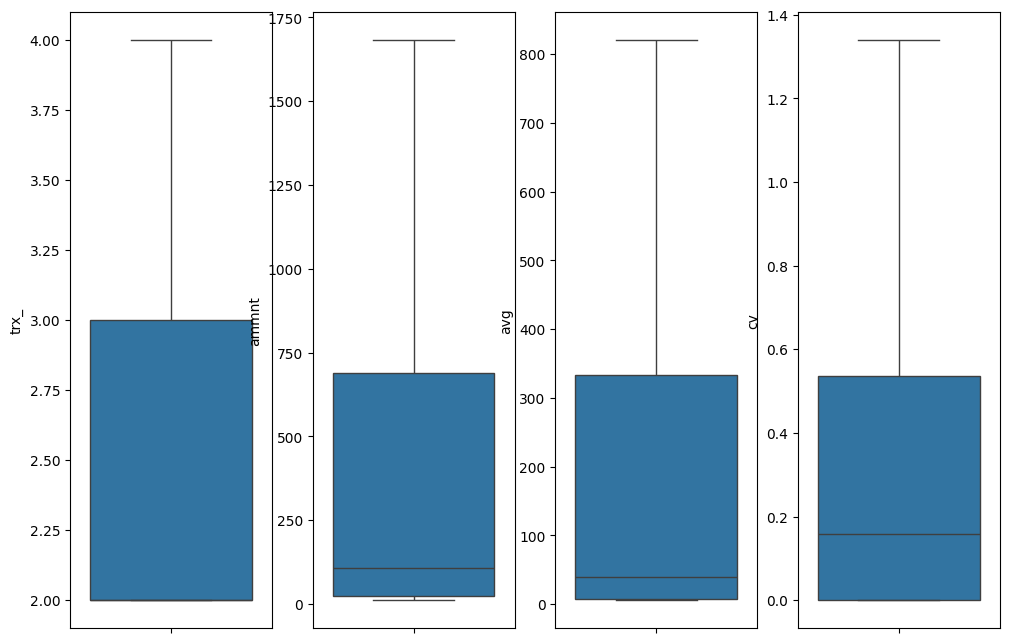

In [21]:
# Reglas heurísticas
def metrica(var): 
    mean = X[var].mean()
    std = X[var].std() # /((X['trx_'].shape[0])**(0.5))
    ucl = mean + 3 * std
    lcl = np.where(mean - 3 * std < 0, 0, mean - 3 * std)
    return ucl, lcl, mean

import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(12, 8))
sns.boxplot(y="trx_", data= trx_an_cre, showfliers=False, ax = axes[0])
sns.boxplot(y="ammnt", data= trx_an_cre, showfliers=False, ax = axes[1])
sns.boxplot(y="avg", data= trx_an_cre, showfliers=False, ax = axes[2])
sns.boxplot(y="cv", data= trx_an_cre, showfliers=False, ax = axes[3])


In [22]:
# Selección de anomalías

features_df['heur_anomaly'] = np.where((features_df['trx_'] > metrica('trx_')[0]) & ((features_df['avg'] < metrica('avg')[2]) | (features_df['cv'] < metrica('cv')[2])), 1, 0)

features_df[features_df['heur_anomaly']==1]

,transaction_type,user_id,date_1,trx_,ammnt,avg,cv,if_anomaly,if_score,heur_anomaly
5072,CREDITO,00bcf49e64276b903e529ee58fb6bcd6,20210211,68,432.756325,6.364064,0.443451,1,-0.735516,1
5073,CREDITO,00bcf49e64276b903e529ee58fb6bcd6,20210212,32,203.300361,6.353136,0.363891,1,-0.643738,1
5310,CREDITO,00c67e61a803dc89bf5894b07d101d7f,20210114,35,208.118937,5.946255,0.000101,1,-0.613793,1
5311,CREDITO,00c67e61a803dc89bf5894b07d101d7f,20210115,34,208.823949,6.141881,0.186132,1,-0.632664,1
6216,CREDITO,00e5bd1cf16668c7a7c29d85bb604140,20210204,95,576.612136,6.069601,0.200965,1,-0.752644,1
...,...,...,...,...,...,...,...,...,...,...
1777302,CREDITO,ff375c635b6281d44560e6d4165fba6b,20210217,89,629.993342,7.078577,1.511502,1,-0.792971,1
1777811,CREDITO,ff43efd9e35916f280da2cdd0be14d76,20210113,92,547.103861,5.946781,0.000207,1,-0.734874,1
1777881,CREDITO,ff465a570b359ed1bae4abf24d68980a,20210205,49,292.616987,5.971775,0.031706,1,-0.655202,1
1781838,CREDITO,ffd25fce0151b5b923c684aa5c8171a4,20210208,100,594.445501,5.944455,0.000000,1,-0.741217,1


##### 3.1.4 Ensamblaje

Se usó el ensamble para robustecer el resultado de los modelos por separado donde se selecciona una trx an+ómala siempre y cuando los dos modelos hayan coincidido

In [23]:
# Emsamblaje
features_df['ensemble_score'] = (features_df['if_anomaly'] + features_df['heur_anomaly']) # + features_df['dbscan_anomaly']
features_df['anomaly'] = (features_df['ensemble_score'] >= 2).astype(int)

In [25]:
# Hallázgos de anomalías por modelo
detection_summary = pd.DataFrame({
    'Isolation Forest': [features_df['if_anomaly'].sum(), f"{features_df['if_anomaly'].mean()*100:.1f}%"],
    #'DBSCAN': [features_df['dbscan_anomaly'].sum(), f"{features_df['dbscan_anomaly'].mean()*100:.1f}%"],
    'Heurístico': [features_df['heur_anomaly'].sum(), f"{features_df['heur_anomaly'].mean()*100:.1f}%"],
    'Ensemble': [features_df['anomaly'].sum(), f"{features_df['anomaly'].mean()*100:.1f}%"]
}, index=['Anomalías Detectadas', 'Porcentaje'])

print("Resumen de detecciones por modelo:")
print(detection_summary)

Resumen de detecciones por modelo:
                     Isolation Forest Heurístico Ensemble
Anomalías Detectadas            16249       2625     2625
Porcentaje                      10.0%       1.6%     1.6%


##### 3.1.5 Análisis de resultados

Se observa que el CV de una trx anómala es menor que una trx normal. Por el otro lado, el número de trx es mayor cuando esta es anómala. Adicionalmente, se observa que el monto de las trx anómalas es menor a una trx normal. Y finalmente, al graficar las trx vs monto se observa que el número de trx superior a cierto límite aumenta los chances a que estas sean anómalas.

In [27]:
# Análisis de casos detectados por el modelo ensemble
suspicious_cases = features_df[features_df['anomaly'] == 1].sort_values('ensemble_score', ascending=False)

print(f"\nTop 10 casos detectados por el modelo ensemble:")

suspicious_cases[['transaction_type', 'date_1', 'trx_', 'ammnt', 'avg', 'cv', 'if_anomaly', 'heur_anomaly', 'heur_anomaly']].head(10) # , 'dbscan_anomaly'


Top 10 casos detectados por el modelo ensemble:


,transaction_type,date_1,trx_,ammnt,avg,cv,if_anomaly,heur_anomaly,heur_anomaly
5072,CREDITO,20210211,68,432.756325,6.364064,0.443451,1,1,1
5073,CREDITO,20210212,32,203.300361,6.353136,0.363891,1,1,1
5310,CREDITO,20210114,35,208.118937,5.946255,0.000101,1,1,1
5311,CREDITO,20210115,34,208.823949,6.141881,0.186132,1,1,1
6216,CREDITO,20210204,95,576.612136,6.069601,0.200965,1,1,1
6217,CREDITO,20210209,88,523.112041,5.944455,0.000000,1,1,1
8315,CREDITO,20210205,27,225.294845,8.344254,0.124214,1,1,1
8316,CREDITO,20210206,26,216.259273,8.317664,0.089078,1,1,1
11976,CREDITO,20210121,51,303.293228,5.946926,0.000169,1,1,1
11977,CREDITO,20210122,42,249.772922,5.946974,0.000148,1,1,1


C:\Users\egarcmor\AppData\Local\Temp\ipykernel_17596\3612912157.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal['cv'], anomalous['cv']], labels=['Normal', 'Anómalo'], showfliers=False)
C:\Users\egarcmor\AppData\Local\Temp\ipykernel_17596\3612912157.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal['trx_'], anomalous['trx_']], labels=['Normal', 'Anómalo'], showfliers=False)
C:\Users\egarcmor\AppData\Local\Temp\ipykernel_17596\3612912157.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal['avg'], anomalous['avg']], labels=['Normal', 'Anómalo'], showflie

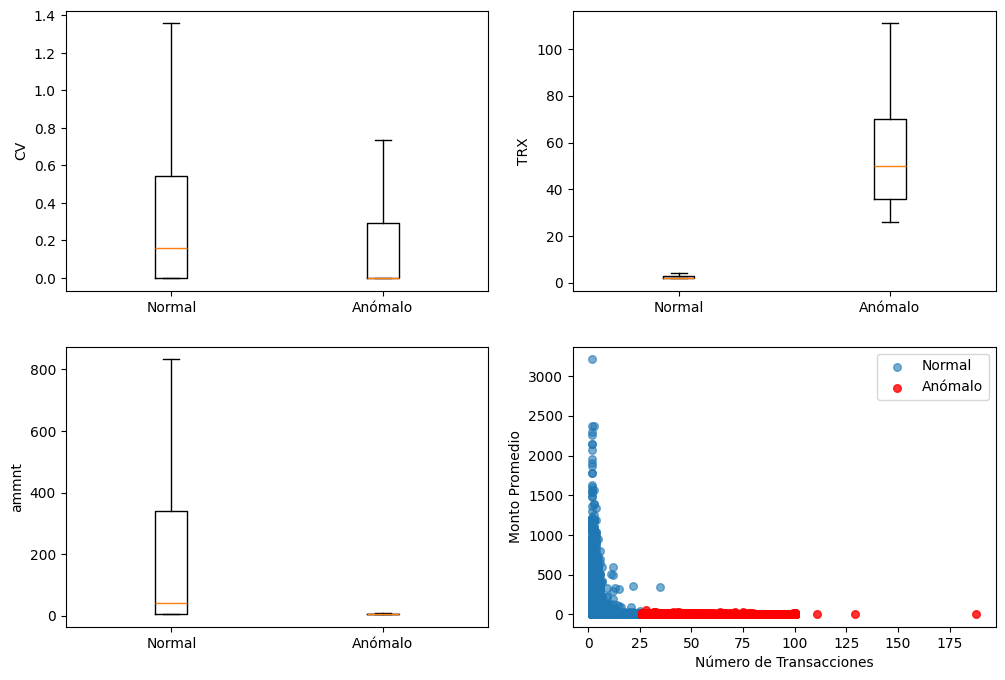

In [28]:
# Características de casos anómalos vs normales
normal = features_df[features_df['anomaly'] == 0]
anomalous = features_df[features_df['anomaly'] == 1]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Coeficiente de variación de montos
plt.subplot(2, 2, 1)
plt.boxplot([normal['cv'], anomalous['cv']], labels=['Normal', 'Anómalo'], showfliers=False)
#plt.title('CV')
plt.ylabel('CV')

# Coeficiente de variación de transacción
plt.subplot(2, 2, 2)
plt.boxplot([normal['trx_'], anomalous['trx_']], labels=['Normal', 'Anómalo'], showfliers=False)
#plt.title('TRX')
plt.ylabel('TRX')

# Coeficiente de variación de transacción
plt.subplot(2, 2, 3)
plt.boxplot([normal['avg'], anomalous['avg']], labels=['Normal', 'Anómalo'], showfliers=False)
#plt.title('TRX')
plt.ylabel('ammnt')

# trx x ammnt 
plt.subplot(2, 2, 4)
plt.scatter(normal['trx_'], normal['avg'], alpha=0.6, label='Normal', s=30)
plt.scatter(anomalous['trx_'], anomalous['avg'], alpha=0.8, label='Anómalo', s=30, c='red')
plt.xlabel('Número de Transacciones')
plt.ylabel('Monto Promedio')
#plt.title('Casos Normales vs Anomalías')
plt.legend()


<Axes: >

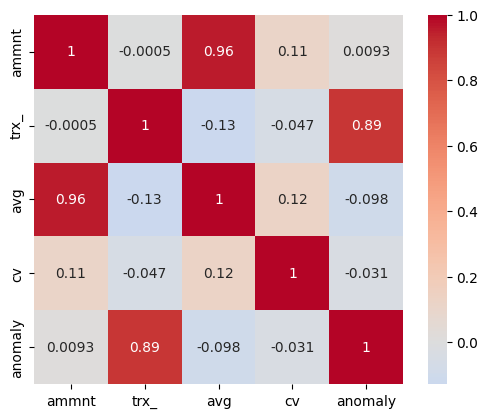

In [29]:
# Matriz de correlación de características principales

correlation_features = ['ammnt', 'trx_', 'avg', 'cv', 'anomaly']
corr_matrix = features_df[correlation_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)


#### Paso 3.2: Modelo para trx débito

Para el modelo de transacciones de débito tomamos las características de transacciones (trx_), el promedio de la transacción (avg) y el coeficiente de variación (cv). La idea de esta última métrica es validar que tanto es la variación de los montos, es decir, que entre más bajo hay menos variación.

In [30]:
feature_columns = ['trx_', 'avg', 'cv']# , 'ammnt',
X = trx_an_deb[feature_columns].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##### 3.2.1 Isolation Forest

In [31]:
# Isolation forest
if_model = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
if_predictions = if_model.fit_predict(X_scaled)
if_scores = if_model.score_samples(X_scaled)

features_df = trx_an_deb.copy()
features_df['if_anomaly'] = (if_predictions == -1).astype(int)
features_df['if_score'] = if_scores

In [32]:
features_df[features_df['if_anomaly']==1]

,transaction_type,user_id,date_1,trx_,ammnt,avg,cv,if_anomaly,if_score
1783056,DEBITO,00024e1898b58ad64c8082c9dd3d4eb4,20211127,2,2021.114704,1010.557352,0.249567,1,-0.563406
1783108,DEBITO,0002ad97e3f83b08a57f8fb018e747fb,20211109,4,2258.892905,564.723226,0.105263,1,-0.596094
1783202,DEBITO,0003cb94365e12f0494846bc39b366ab,20210210,4,2258.892905,564.723226,0.526316,1,-0.570831
1783263,DEBITO,00044d53ab4ee615152f3d3bb448c523,20210805,2,2377.782005,1188.891002,0.000000,1,-0.585192
1783264,DEBITO,00044d53ab4ee615152f3d3bb448c523,20210806,2,2377.782005,1188.891002,0.000000,1,-0.585192
...,...,...,...,...,...,...,...,...,...
9292423,DEBITO,fffb3d0809b2b15358fe2c30244b04eb,20211130,2,2615.560205,1307.780103,0.128565,1,-0.609462
9292506,DEBITO,fffc14c1ba0569fbdfaff5affa12dcbe,20210424,4,2841.449496,710.362374,0.008368,1,-0.586735
9292694,DEBITO,fffd39d8470742977525fe9c2fee109e,20210712,2,2377.782005,1188.891002,0.000000,1,-0.585192
9292704,DEBITO,fffd5c0647fb4861259e915fe588bc59,20210610,2,2377.782005,1188.891002,0.000000,1,-0.585192


##### 3.2.2 DBSCAN

In [31]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
features_df['dbscan_cluster'] = dbscan_labels
features_df['dbscan_anomaly'] = (dbscan_labels == -1).astype(int)

In [32]:
features_df[features_df['dbscan_anomaly']==1]

,transaction_type,user_id,date_1,trx_,ammnt,avg,cv,if_anomaly,if_score,dbscan_cluster,dbscan_anomaly
185597,DEBITO,09ef9d0c0923b7f4848655f0de449603,20210109,79,1742.319764,22.054681,0.572719,1,-0.749037,-1,1
185598,DEBITO,09ef9d0c0923b7f4848655f0de449603,20210111,62,1307.780102,21.093227,0.544072,1,-0.728471,-1,1
185600,DEBITO,09ef9d0c0923b7f4848655f0de449603,20210120,83,1676.930758,20.203985,0.496821,1,-0.748772,-1,1
192782,DEBITO,0dd3e961a5b7328a7491cf2276caca11,20210115,22,208.082081,9.458276,1.741907,1,-0.722953,-1,1
196557,DEBITO,0ff36dad15dc31bed02c840d1c777963,20210123,31,428.025727,13.807282,1.627616,1,-0.724577,-1,1
...,...,...,...,...,...,...,...,...,...,...,...
589695,DEBITO,e996e08fb1f7ee5f259a2031a931073d,20210130,66,653.890051,9.907425,0.570020,1,-0.721100,-1,1
590236,DEBITO,e9e030b082b2c004a385916046c677a9,20210109,86,743.161499,8.641413,2.892946,1,-0.784744,-1,1
599819,DEBITO,eefbc8d3ff3a5b0200d385aa2e894035,20210101,71,535.317196,7.539679,1.777732,1,-0.774642,-1,1
604172,DEBITO,f177df9b33a7026d4e5fa32ab8c766c7,20210121,84,642.095063,7.643989,1.320002,1,-0.768379,-1,1


##### 3.2.3 Reglas heurísticas

Para las reglas heurísticas, se usó los límites de control (con 3 desviaciones estándar) para definir las reglas para considerar una trx anómala

<Axes: ylabel='cv'>

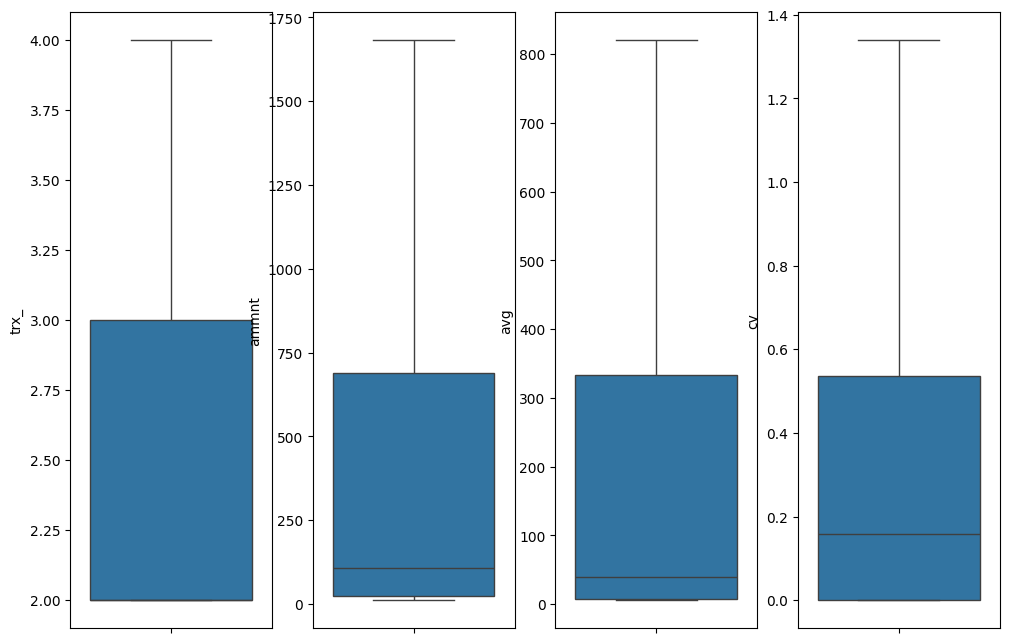

In [33]:
# Reglas heurísticas
def metrica(var): 
    mean = X[var].mean()
    std = X[var].std() # /((X['trx_'].shape[0])**(0.5))
    ucl = mean + 3 * std
    lcl = np.where(mean - 3 * std < 0, 0, mean - 3 * std)
    return ucl, lcl, mean

import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(12, 8))
sns.boxplot(y="trx_", data= trx_an_cre, showfliers=False, ax = axes[0])
sns.boxplot(y="ammnt", data= trx_an_cre, showfliers=False, ax = axes[1])
sns.boxplot(y="avg", data= trx_an_cre, showfliers=False, ax = axes[2])
sns.boxplot(y="cv", data= trx_an_cre, showfliers=False, ax = axes[3])

In [34]:
# Selección de anomalías
features_df['heur_anomaly'] = np.where((features_df['trx_'] > metrica('trx_')[0]) & ((features_df['avg'] < metrica('avg')[2]) | (features_df['cv'] < metrica('cv')[2])), 1, 0)
features_df[features_df['heur_anomaly']==1]

,transaction_type,user_id,date_1,trx_,ammnt,avg,cv,if_anomaly,if_score,heur_anomaly
1790975,DEBITO,004a63b9c469d2bfc7e3ce29c3edd462,20210210,40,242.533764,6.063344,0.000000,1,-0.739198,1
1790976,DEBITO,004a63b9c469d2bfc7e3ce29c3edd462,20210211,26,183.326992,7.051038,0.041238,1,-0.719067,1
1797826,DEBITO,00897a7d3555bb00d4b80596dbf668a6,20210310,13,120.077991,9.236769,0.204554,1,-0.667562,1
1803976,DEBITO,00bf77a52b635dd43c01384fa5e97346,20210123,22,130.778010,5.944455,0.000000,1,-0.697925,1
1803977,DEBITO,00bf77a52b635dd43c01384fa5e97346,20210124,78,463.667491,5.944455,0.000000,1,-0.777218,1
...,...,...,...,...,...,...,...,...,...,...
9287745,DEBITO,ffd25fce0151b5b923c684aa5c8171a4,20210215,23,184.278105,8.012092,0.190960,1,-0.705155,1
9287746,DEBITO,ffd25fce0151b5b923c684aa5c8171a4,20210216,77,588.501046,7.642871,0.173786,1,-0.771604,1
9289331,DEBITO,ffe087343f4c8aad20e37122eac9b85c,20210107,19,112.970801,5.945832,0.000203,1,-0.688941,1
9289332,DEBITO,ffe087343f4c8aad20e37122eac9b85c,20210108,58,344.842591,5.945562,0.000201,1,-0.767147,1


##### 3.2.4 Ensamblaje

Se usó el ensamble para robustecer el resultado de los modelos por separado donde se selecciona una trx an+ómala siempre y cuando los dos modelos hayan coincidido

In [35]:
# Emsamblaje
features_df['ensemble_score'] = (features_df['if_anomaly']  + features_df['heur_anomaly']) # + features_df['dbscan_anomaly']
features_df['anomaly'] = (features_df['ensemble_score'] >= 2).astype(int)

In [36]:
# Hallázgos de anomalías por modelo
detection_summary = pd.DataFrame({
    'Isolation Forest': [features_df['if_anomaly'].sum(), f"{features_df['if_anomaly'].mean()*100:.1f}%"],
    # 'DBSCAN': [features_df['dbscan_anomaly'].sum(), f"{features_df['dbscan_anomaly'].mean()*100:.1f}%"],
    'Heurístico': [features_df['heur_anomaly'].sum(), f"{features_df['heur_anomaly'].mean()*100:.1f}%"],
    'Ensemble': [features_df['anomaly'].sum(), f"{features_df['anomaly'].mean()*100:.1f}%"]
}, index=['Anomalías Detectadas', 'Porcentaje'])

print("Resumen de detecciones por modelo:")
print(detection_summary)

Resumen de detecciones por modelo:
                     Isolation Forest Heurístico Ensemble
Anomalías Detectadas            73997       3694     3694
Porcentaje                      10.0%       0.5%     0.5%


##### 3.2.5 Análisis de resultados

Se observa que el CV de una trx anómala es menor que una trx normal. Por el otro lado, el número de trx es mayor cuando esta es anómala. Adicionalmente, se observa que el monto de las trx anómalas es menor a una trx normal. Y finalmente, al graficar las trx vs monto se observa que el número de trx superior a cierto límite aumenta los chances a que estas sean anómalas.

In [37]:
# Análisis de casos detectados por el modelo ensemble
suspicious_cases = features_df[features_df['anomaly'] == 1].sort_values('ensemble_score', ascending=False)

print(f"\nTop 10 casos detectados por el modelo ensemble:")

suspicious_cases[['transaction_type', 'date_1', 'trx_', 'ammnt', 'avg', 'cv', 'if_anomaly', 'heur_anomaly', 'heur_anomaly']].head(10) # , 'dbscan_anomaly'


Top 10 casos detectados por el modelo ensemble:


,transaction_type,date_1,trx_,ammnt,avg,cv,if_anomaly,heur_anomaly,heur_anomaly
1790975,DEBITO,20210210,40,242.533764,6.063344,0.000000,1,1,1
1790976,DEBITO,20210211,26,183.326992,7.051038,0.041238,1,1,1
1797826,DEBITO,20210310,13,120.077991,9.236769,0.204554,1,1,1
1803976,DEBITO,20210123,22,130.778010,5.944455,0.000000,1,1,1
1803977,DEBITO,20210124,78,463.667491,5.944455,0.000000,1,1,1
1804813,DEBITO,20210110,17,101.085457,5.946203,0.000103,1,1,1
1804814,DEBITO,20210111,83,493.533622,5.946188,0.000100,1,1,1
1808605,DEBITO,20210205,91,540.945406,5.944455,0.000000,1,1,1
1816546,DEBITO,20210208,24,194.621457,8.109227,0.016164,1,1,1
1816547,DEBITO,20210209,25,203.062583,8.122503,0.014465,1,1,1


C:\Users\egarcmor\AppData\Local\Temp\ipykernel_17596\2891077651.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal['cv'], anomalous['cv']], labels=['Normal', 'Anómalo'], showfliers=False)
C:\Users\egarcmor\AppData\Local\Temp\ipykernel_17596\2891077651.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal['trx_'], anomalous['trx_']], labels=['Normal', 'Anómalo'], showfliers=False)
C:\Users\egarcmor\AppData\Local\Temp\ipykernel_17596\2891077651.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal['avg'], anomalous['avg']], labels=['Normal', 'Anómalo'], showflie

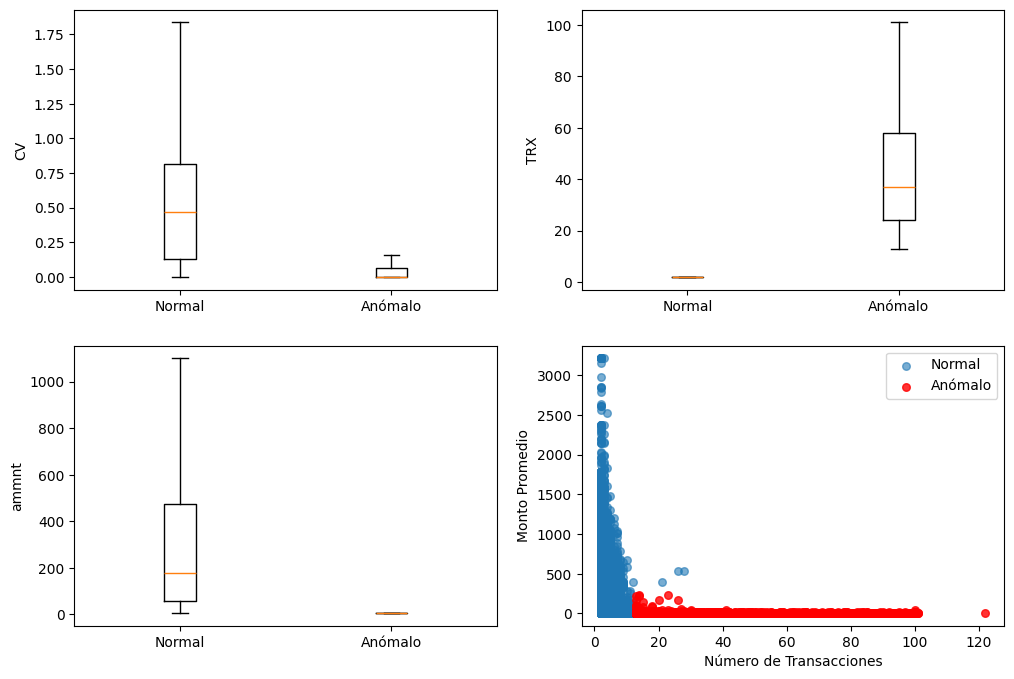

In [38]:
# Características de casos anómalos vs normales
normal = features_df[features_df['anomaly'] == 0]
anomalous = features_df[features_df['anomaly'] == 1]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Coeficiente de variación de montos
plt.subplot(2, 2, 1)
plt.boxplot([normal['cv'], anomalous['cv']], labels=['Normal', 'Anómalo'], showfliers=False)
#plt.title('CV')
plt.ylabel('CV')

# Coeficiente de variación de transacción
plt.subplot(2, 2, 2)
plt.boxplot([normal['trx_'], anomalous['trx_']], labels=['Normal', 'Anómalo'], showfliers=False)
#plt.title('TRX')
plt.ylabel('TRX')

# Coeficiente de variación de transacción
plt.subplot(2, 2, 3)
plt.boxplot([normal['avg'], anomalous['avg']], labels=['Normal', 'Anómalo'], showfliers=False)
#plt.title('TRX')
plt.ylabel('ammnt')

# trx x ammnt 
plt.subplot(2, 2, 4)
plt.scatter(normal['trx_'], normal['avg'], alpha=0.6, label='Normal', s=30)
plt.scatter(anomalous['trx_'], anomalous['avg'], alpha=0.8, label='Anómalo', s=30, c='red')
plt.xlabel('Número de Transacciones')
plt.ylabel('Monto Promedio')
#plt.title('Casos Normales vs Anomalías')
plt.legend()

### Paso 3.3: Frecuencia de actualización de datos

Luego de analizar algunos casos de usuarios con transacciones anómalas, se observa que estas transacciones ocurren en el trascurso de minutos. Por lo que la frecuencia debería al menos de actualización cada minuto siendo ideal, actualización cada 15 o 20 segundos. A continuación se muestra el soporte de esta recomendación.

In [39]:
# Transacciones por usr
df_1_sample_ex = df_1_sample[df_1_sample['date_1']==20210110].copy()
trx_freq = pd.DataFrame(df_1_sample_ex['user_id'].value_counts()).reset_index()
trx_freq.columns = ['user_id', 'n_trx']
#print(trx_usr[trx_usr['n_trx']>1].shape)
trx_freq.head()

,user_id,n_trx
0,55053ead9cf922c4b96d7003c2f7cfb6,157
1,507e9e33c91804804a351de40e160b47,151
2,316da47ffafffd546acf7be665bcd309,126
3,8d5e4a03dde0a2fd8abe6a8557fefe60,111
4,e2944117310fcd4690f5b4639bda45bb,108


In [40]:
df_1_sample_ex['fecha'] = pd.to_datetime(df_1_sample_ex['fecha'])
df_1_sample_ex['hora'] = df_1_sample_ex['fecha'].dt.hour
df_1_sample_ex['minuto'] = df_1_sample_ex['fecha'].dt.minute

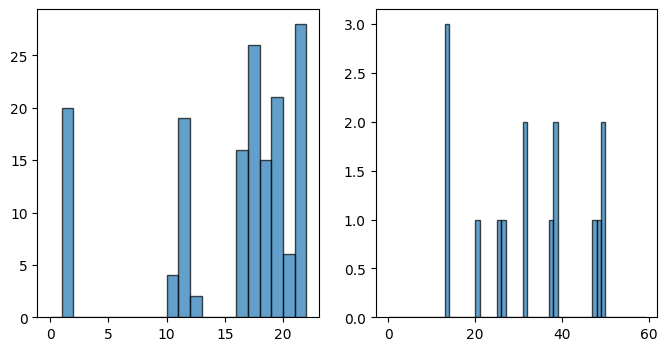

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# Distribución de trx por hora para un caso anómalo
plt.subplot(1, 2, 1)
plt.hist(df_1_sample_ex[df_1_sample_ex['user_id']=='55053ead9cf922c4b96d7003c2f7cfb6']['hora'], bins=range(0, 23), alpha=0.7, edgecolor='black')

# Distribución de trx por minuto para un caso anómalo
plt.subplot(1, 2, 2)
plt.hist(df_1_sample_ex[(df_1_sample_ex['user_id']=='55053ead9cf922c4b96d7003c2f7cfb6') & (df_1_sample_ex['hora']==18)]['minuto'], bins=range(0, 60), alpha=0.7, edgecolor='black')
plt.show()


In [42]:
df_1_sample_ex[(df_1_sample_ex['user_id']=='55053ead9cf922c4b96d7003c2f7cfb6') & (df_1_sample_ex['hora']==18)]

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,fecha,date_1,hora,minuto
10395383,838a8fa992a4aa2fb5a0cf8b15b63755,4dc6564fc9b44156f6e7c2606aa1d862,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:13:06,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94564390,CREDITO,2021-01-10 18:13:06,20210110,18,13
9712651,838a8fa992a4aa2fb5a0cf8b15b63755,4a7f266b1b86992f0b7ab50a7c8cd12d,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:13:32,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94683279,DEBITO,2021-01-10 18:13:32,20210110,18,13
10395396,838a8fa992a4aa2fb5a0cf8b15b63755,281b3878294df5e4223de87d01f8146a,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:13:47,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94802168,CREDITO,2021-01-10 18:13:47,20210110,18,13
10395355,838a8fa992a4aa2fb5a0cf8b15b63755,7e91a93db6580b68fdab17b87f36f1c1,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:20:31,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94802168,CREDITO,2021-01-10 18:20:31,20210110,18,20
10395350,838a8fa992a4aa2fb5a0cf8b15b63755,830846fa44b5e248583edecd88160d4b,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:25:36,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94564390,CREDITO,2021-01-10 18:25:36,20210110,18,25
10395371,838a8fa992a4aa2fb5a0cf8b15b63755,67292a3a78a4e403e97ea1e9ace12227,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:26:21,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94802168,CREDITO,2021-01-10 18:26:21,20210110,18,26
9712658,838a8fa992a4aa2fb5a0cf8b15b63755,52649d8c06e89b4609dc83b8c37fdf96,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:31:45,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94683279,DEBITO,2021-01-10 18:31:45,20210110,18,31
10395393,838a8fa992a4aa2fb5a0cf8b15b63755,77ad421138964f3d3ef566890ced101a,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:31:59,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94802168,CREDITO,2021-01-10 18:31:59,20210110,18,31
9712661,838a8fa992a4aa2fb5a0cf8b15b63755,57cbec6f392c8ded4ebc1f1cea610c88,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:37:35,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94445501,DEBITO,2021-01-10 18:37:35,20210110,18,37
9712629,838a8fa992a4aa2fb5a0cf8b15b63755,6364f7df156480ea274213da92ce5037,f54e0b6b32831a6307361ed959903e76,2021-01-10 18:38:23,c6fa089e30f24688f4c18bc822c3dae2,55053ead9cf922c4b96d7003c2f7cfb6,5.94683279,DEBITO,2021-01-10 18:38:23,20210110,18,38


### Paso 3.4: Arquitectura ideal y recursos necesarios

Una posible arquitectura para desplegar esta propuesta es usar la infraestructura de AWS. Para ello se hace uso de los servicios de Glue, S3, Athena, Sagemaker y Quicksight. 

- En S3 + Athena se realiza el almacenamiento de la información y la realización de consultas a SQL.
- En Glue se hace el tema de ingeniería de datos y preprocesamiento de la información. La cual se almacena en un S3 para que quede de fácil consumo para el modelado en Sagemaker.
- En Sagemaker se genera el modelado y la construcción de pipeline para la ejecución frecuente (cada minuto)
- Y en quicksight, se construye el dashboard  para monitoreo de las anomalías

## Fin